# Compare new model predictions with old

We plan to use the old model as a fallback if the DeepFantasyModel cannot make predictions for a certain player. In this notebook we check the name match rate betweeen the two predictions and compare the actual predictions.

## Set-up

In [1]:
import os
import difflib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pyarrow.parquet as pq
import unidecode

In [2]:
os.chdir('../..')

In [3]:
from src.models.DeepFantasyFootball.make_predictions import DeepFantasyFootball, load_retro_data
from src.models.constants import SEASON_ORDER_DICT
from src.data.s3_utilities import s3_filesystem

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 3

## Make predictions

In [6]:
SEASON_ORDER_DICT

{'2011-12': -4,
 '2012-13': -3,
 '2013-14': -2,
 '2014-15': -1,
 '2015-16': 0,
 '2016-17': 1,
 '2017-18': 2,
 '2018-19': 3,
 '2019-20': 4}

In [7]:
%%time
retro_data = load_retro_data()

CPU times: user 1.75 s, sys: 577 ms, total: 2.32 s
Wall time: 5.69 s


In [8]:
print(retro_data.shape)
retro_data.head()

(175365, 86)


,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek,season_order
4479,1,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0,4
9170,2,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.45,1.21,2.41,1.0,0,0,0,0,0,2.30,1.34,2.29,1.0,0.0,0.0,0.0,4
13811,3,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.30,1.34,2.29,1.0,0,0,0,0,0,10.67,30.23,0.09,0.0,0.0,1.0,0.0,4
18557,4,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,inf,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0,10.67,30.23,0.09,0.0,0,1,0,0,0,2.40,1.14,2.67,1.0,0.0,0.0,0.0,4
23303,5,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,2.2,0.0,0.0,0.0,42.9,0.0,0.0,0.0,50.0,0.0,1.0,0,1,0,0,2.40,1.14,2.67,1.0,0,0,0,0,0,2.22,2.26,1.40,0.0,0.0,0.0,0.0,4


In [9]:
PREVIOUS_GW = 37
PREDICTION_SEASON = '2019-20'
PREDICTION_SEASON_ORDER = SEASON_ORDER_DICT[PREDICTION_SEASON]

In [10]:
lstm_pred = DeepFantasyFootball(
    previous_gw=PREVIOUS_GW,
    prediction_season_order=PREDICTION_SEASON_ORDER,
    previous_gw_was_double_gw=False  # Remove parameter
)

In [11]:
player_list, player_data_list = lstm_pred.prepare_data_for_lstm(full_data=retro_data)

2020-08-20 17:25:33,946 - Number of players available for selection: 69891.0
2020-08-20 17:25:34,197 - Player data shape before: (69891, 86)
2020-08-20 17:25:34,367 - Player data shape after removing players with insufficient GW data: (69891, 86)
2020-08-20 17:25:34,983 - Player data shape after only keeping records needed for LSTM: (2575, 86)


In [12]:
unformatted_predictions = lstm_pred.make_player_predictions(
    player_data_list=player_data_list
)

2020-08-20 17:25:35,287 - LSTM input array shape: (515, 5, 62)


In [13]:
final_predictions = lstm_pred.format_predictions(
    player_list=player_list,
    final_predictions=unformatted_predictions,
    full_data=retro_data,
    double_gw_teams=[]
)

In [14]:
final_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name
362,4.693678,5.444914,5.323153,5.383663,5.191183,26.036591,mohamed_salah,0,0,0,1,Liverpool
359,5.171214,4.905401,4.958048,4.852612,4.653709,24.540983,michail_antonio,0,0,0,1,West Ham United
417,5.635809,4.782982,4.795497,4.633985,4.542773,24.391047,raheem_sterling,0,0,0,1,Manchester City
174,5.722478,4.530327,4.570406,4.392125,4.294994,23.510330,gabriel_fernando de jesus,0,1,0,0,Manchester City
231,4.702238,4.781237,4.753529,4.683409,4.510835,23.431248,jamie_vardy,0,1,0,0,Leicester City


In [15]:
final_predictions.shape

(515, 12)

### Old model predictions

In [16]:
old_model_predictions = pq.read_table(
    's3://fpl-analysis-data/gw_retro_predictions/season=2019-20/gw=37/7d40aff1508d4682b521d25942297dd5.parquet',
    filesystem=s3_filesystem
).to_pandas()

print(old_model_predictions.shape)
old_model_predictions.head()

(651, 14)


,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,model
0,6.336970,6.097189,6.111311,6.005473,6.026895,30.577839,mohamed_salah,0,0,0,1,Liverpool,12.5,lstm_v4
1,5.727709,5.511150,5.521457,5.419328,5.436365,27.616009,kevin_de bruyne,0,0,0,1,Manchester City,10.7,lstm_v4
2,5.560776,5.348629,5.356105,5.254405,5.269376,26.789291,raheem_sterling,0,0,0,1,Manchester City,11.9,lstm_v4
3,5.533156,5.319711,5.326170,5.223664,5.238142,26.640842,bruno miguel_borges fernandes,0,0,0,1,Manchester United,9.1,lstm_v4
4,5.479998,5.269862,5.275545,5.174131,5.187855,26.387390,sadio_mané,0,0,0,1,Liverpool,12.2,lstm_v4


### Merge on name

In [17]:
old_model_predictions.merge(final_predictions, on='name', how='outer', indicator=True)['_merge'].value_counts()

both          450
left_only     201
right_only     65
Name: _merge, dtype: int64

`right_only` are cases of names in the new model predictions but not in the old. We would expect these to be in the old predictions so this mismatch is likely due to punctuation, whitespace or differences in name (short vs full).

We would expect there to be a high number of `left_only` cases given that the FPL dataset, on which the old predictions are made, includes bench warmers. These player play 0 minutes so are not in the new predictions based on Fantasy Football Scout data.

### Remove accents and whitespace in names

In [18]:
final_predictions['name_formatted'] = final_predictions['name'].str.replace(' ', '_').apply(lambda string: unidecode.unidecode(string))

In [19]:
old_model_predictions['name_formatted'] = old_model_predictions['name'].str.replace(' ', '_').apply(lambda string: unidecode.unidecode(string))

In [20]:
old_model_predictions.merge(final_predictions, on='name_formatted', how='outer', indicator=True)['_merge'].value_counts()

both          484
left_only     167
right_only     31
Name: _merge, dtype: int64

More than halved cases of `right_only` but still room for improvement

In [21]:
temp_combined = old_model_predictions.merge(final_predictions, on='name_formatted', how='outer', indicator=True, suffixes=('_old', '_new'))
temp_combined[temp_combined['_merge'] == 'right_only']['name_formatted']

651             kepa_arrizabalaga_revuelta
652    roberto_firmino_barbosa_de_oliveira
653          raul_alonso_jimenez_rodriguez
654                         mahmoud_hassan
655             rodrigo_hernandez_cascante
656                  ayoze_perez_gutierrez
657                    ashley_roy_westwood
658                       phillip_bardsley
659                victor_nilsson-lindelof
660                          joao_moutinho
661                            luke_thomas
662                            oriol_romeu
663           diogo_jose_teixeira_da_silva
664                  onyinye_wilfred_ndidi
665                     mbwana_aly_samatta
666                           robert_brady
667            cedric_ricardo_alves_soares
668                         kenneth_mclean
669                       ahmed_elmohamady
670                           george_hirst
671                       emile_smith-rowe
672                          jesus_vallejo
673                        roberto_jimenez
674        

Looks like short form vs long form problem

### Look for closest name match

The mismatched names in `right_only` should have a close match to a name in `left_only`. We use `difflib` to find these.

In [23]:
name_matches = old_model_predictions[['name_formatted']].merge(final_predictions['name_formatted'], on='name_formatted', how='outer', indicator=True)
name_matches.head()

,name_formatted,_merge
0,mohamed_salah,both
1,kevin_de_bruyne,both
2,raheem_sterling,both
3,bruno_miguel_borges_fernandes,both
4,sadio_mane,both


In [24]:
name_matches.loc[name_matches['_merge'] == 'right_only', 'name_closest_fpl_match'] = name_matches.loc[name_matches['_merge'] == 'right_only', 'name_formatted'].apply(
    lambda x: difflib.get_close_matches(
        x,
        name_matches[name_matches['_merge'] == 'left_only']['name_formatted'], 
        n=1, 
        cutoff=0  # Set to 0 to prevent empty list from being returned
    )[0]
)

Set cut-off of similarity to zero to reduce risk of empty list (i.e. no matches). We can join on team name and closest name to mitigate the chance of merging predictions for the wrong player.

In [25]:
name_matches.head()

,name_formatted,_merge,name_closest_fpl_match
0,mohamed_salah,both,NaN
1,kevin_de_bruyne,both,NaN
2,raheem_sterling,both,NaN
3,bruno_miguel_borges_fernandes,both,NaN
4,sadio_mane,both,NaN


In [26]:
final_predictions.shape

(515, 13)

In [27]:
final_predictions = final_predictions.merge(name_matches, on='name_formatted', how='left')
print(final_predictions.shape)
final_predictions.head()

(515, 15)


,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name,name_formatted,_merge,name_closest_fpl_match
0,4.693678,5.444914,5.323153,5.383663,5.191183,26.036591,mohamed_salah,0,0,0,1,Liverpool,mohamed_salah,both,NaN
1,5.171214,4.905401,4.958048,4.852612,4.653709,24.540983,michail_antonio,0,0,0,1,West Ham United,michail_antonio,both,NaN
2,5.635809,4.782982,4.795497,4.633985,4.542773,24.391047,raheem_sterling,0,0,0,1,Manchester City,raheem_sterling,both,NaN
3,5.722478,4.530327,4.570406,4.392125,4.294994,23.510330,gabriel_fernando de jesus,0,1,0,0,Manchester City,gabriel_fernando_de_jesus,both,NaN
4,4.702238,4.781237,4.753529,4.683409,4.510835,23.431248,jamie_vardy,0,1,0,0,Leicester City,jamie_vardy,both,NaN


In [28]:
final_predictions.drop(columns=['_merge'], inplace=True)

In [29]:
final_predictions['name_join_key'] = np.where(
    final_predictions['name_closest_fpl_match'].isnull(),
    final_predictions['name_formatted'],
    final_predictions['name_closest_fpl_match']
) 

In [30]:
assert final_predictions['name_join_key'].isnull().sum() == 0

### Align team names

In [31]:
set(old_model_predictions['team_name']) - set(final_predictions['team_name'])

{'Brighton & Hove Albion'}

In [32]:
set(final_predictions['team_name']) - set(old_model_predictions['team_name'])

{'Brighton and Hove Albion'}

In [33]:
final_predictions['team_name'].replace({'Brighton and Hove Albion': 'Brighton & Hove Albion'}, inplace=True)

In [34]:
combined = old_model_predictions.merge(final_predictions, left_on=['name_formatted', 'team_name'], right_on=['name_join_key', 'team_name'], how='outer', indicator=True, suffixes=('_old', '_new'))
combined.head()

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,model,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_closest_fpl_match,name_join_key,_merge
0,6.336970,6.097189,6.111311,6.005473,6.026895,30.577839,mohamed_salah,0.0,0.0,0.0,1.0,Liverpool,12.5,lstm_v4,mohamed_salah,4.693678,5.444914,5.323153,5.383663,5.191183,26.036591,mohamed_salah,0.0,0.0,0.0,1.0,mohamed_salah,NaN,mohamed_salah,both
1,5.727709,5.511150,5.521457,5.419328,5.436365,27.616009,kevin_de bruyne,0.0,0.0,0.0,1.0,Manchester City,10.7,lstm_v4,kevin_de_bruyne,4.961794,3.821179,3.877621,3.661717,3.565015,19.887327,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,NaN,kevin_de_bruyne,both
2,5.560776,5.348629,5.356105,5.254405,5.269376,26.789291,raheem_sterling,0.0,0.0,0.0,1.0,Manchester City,11.9,lstm_v4,raheem_sterling,5.635809,4.782982,4.795497,4.633985,4.542773,24.391047,raheem_sterling,0.0,0.0,0.0,1.0,raheem_sterling,NaN,raheem_sterling,both
3,5.533156,5.319711,5.326170,5.223664,5.238142,26.640842,bruno miguel_borges fernandes,0.0,0.0,0.0,1.0,Manchester United,9.1,lstm_v4,bruno_miguel_borges_fernandes,3.982200,4.509116,4.390882,4.420859,4.318761,21.621819,bruno_miguel borges fernandes,0.0,0.0,0.0,1.0,bruno_miguel_borges_fernandes,NaN,bruno_miguel_borges_fernandes,both
4,5.479998,5.269862,5.275545,5.174131,5.187855,26.387390,sadio_mané,0.0,0.0,0.0,1.0,Liverpool,12.2,lstm_v4,sadio_mane,3.708805,3.778066,3.673570,3.601927,3.498488,18.260857,sadio_mane,0.0,0.0,0.0,1.0,sadio_mane,NaN,sadio_mane,both


In [35]:
combined['_merge'].value_counts()

both          505
left_only     146
right_only     10
Name: _merge, dtype: int64

Now only 10 in `right_only`

In [36]:
combined[combined['_merge'] == 'right_only']

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,model,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_closest_fpl_match,name_join_key,_merge
651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham Hotspur,NaN,NaN,NaN,2.564655,2.678423,2.561055,2.553812,2.531832,12.889776,kyle_walker-peters,1.0,0.0,0.0,0.0,kyle_walker-peters,NaN,kyle_walker-peters,right_only
652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leicester City,NaN,NaN,NaN,2.707033,2.390533,2.286281,2.177002,2.152015,11.712864,luke_thomas,1.0,0.0,0.0,0.0,luke_thomas,luke_amos,luke_amos,right_only
653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Liverpool,NaN,NaN,NaN,2.269612,2.365203,2.263433,2.241791,2.147068,11.287107,harry_wilson,0.0,0.0,0.0,1.0,harry_wilson,NaN,harry_wilson,right_only
654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tottenham Hotspur,NaN,NaN,NaN,1.944025,1.923698,1.816696,1.783265,1.768977,9.236662,danny_rose,1.0,0.0,0.0,0.0,danny_rose,NaN,danny_rose,right_only
655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wolverhampton Wanderers,NaN,NaN,NaN,1.491928,1.860778,1.788418,1.831426,1.818180,8.790730,diogo_josé teixeira da silva,0.0,1.0,0.0,0.0,diogo_jose_teixeira_da_silva,danilo_luiz_da_silva,danilo_luiz_da_silva,right_only
656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Southampton,NaN,NaN,NaN,1.937992,1.431328,1.462170,1.369748,1.374952,7.576190,cedric_ricardo alves soares,1.0,0.0,0.0,0.0,cedric_ricardo_alves_soares,cedric_soares,cedric_soares,right_only
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leicester City,NaN,NaN,NaN,1.057847,1.131612,1.084508,1.065766,1.036857,5.376590,george_hirst,0.0,1.0,0.0,0.0,george_hirst,joe_hart,joe_hart,right_only
658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wolverhampton Wanderers,NaN,NaN,NaN,0.734442,1.161039,1.087372,1.156968,1.180281,5.320101,ryan_bennett,1.0,0.0,0.0,0.0,ryan_bennett,NaN,ryan_bennett,right_only
659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manchester City,NaN,NaN,NaN,0.354608,0.379001,0.481167,0.491438,0.557964,2.264177,patrick_roberts,0.0,0.0,0.0,1.0,patrick_roberts,NaN,patrick_roberts,right_only
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chelsea,NaN,NaN,NaN,0.264765,0.408907,0.472664,0.537323,0.571101,2.254759,daniel_drinkwater,0.0,0.0,0.0,1.0,daniel_drinkwater,NaN,daniel_drinkwater,right_only


Looks like some are cases where the team is different e.g. cedric_soares. Let's print these names out in prod but discard them for now. In any case the old model will be used for these players.

In [38]:
combined.head()

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,model,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_closest_fpl_match,name_join_key,_merge
0,6.336970,6.097189,6.111311,6.005473,6.026895,30.577839,mohamed_salah,0.0,0.0,0.0,1.0,Liverpool,12.5,lstm_v4,mohamed_salah,4.693678,5.444914,5.323153,5.383663,5.191183,26.036591,mohamed_salah,0.0,0.0,0.0,1.0,mohamed_salah,NaN,mohamed_salah,both
1,5.727709,5.511150,5.521457,5.419328,5.436365,27.616009,kevin_de bruyne,0.0,0.0,0.0,1.0,Manchester City,10.7,lstm_v4,kevin_de_bruyne,4.961794,3.821179,3.877621,3.661717,3.565015,19.887327,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,NaN,kevin_de_bruyne,both
2,5.560776,5.348629,5.356105,5.254405,5.269376,26.789291,raheem_sterling,0.0,0.0,0.0,1.0,Manchester City,11.9,lstm_v4,raheem_sterling,5.635809,4.782982,4.795497,4.633985,4.542773,24.391047,raheem_sterling,0.0,0.0,0.0,1.0,raheem_sterling,NaN,raheem_sterling,both
3,5.533156,5.319711,5.326170,5.223664,5.238142,26.640842,bruno miguel_borges fernandes,0.0,0.0,0.0,1.0,Manchester United,9.1,lstm_v4,bruno_miguel_borges_fernandes,3.982200,4.509116,4.390882,4.420859,4.318761,21.621819,bruno_miguel borges fernandes,0.0,0.0,0.0,1.0,bruno_miguel_borges_fernandes,NaN,bruno_miguel_borges_fernandes,both
4,5.479998,5.269862,5.275545,5.174131,5.187855,26.387390,sadio_mané,0.0,0.0,0.0,1.0,Liverpool,12.2,lstm_v4,sadio_mane,3.708805,3.778066,3.673570,3.601927,3.498488,18.260857,sadio_mane,0.0,0.0,0.0,1.0,sadio_mane,NaN,sadio_mane,both


In [39]:
combined[combined['_merge'] != 'right_only'].shape

(651, 30)

__Note:__ In prod select predictions to use based on what is available. May want to keep FPL names to make things easier for fpl-team-selector. Also save dictionary of team mappings.

## Compare MSE of new model vs old for this gameweek

In [40]:
both = combined[combined['_merge'] == 'both']
both.reset_index(drop=True, inplace=True)
both.head()

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,model,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_closest_fpl_match,name_join_key,_merge
0,6.336970,6.097189,6.111311,6.005473,6.026895,30.577839,mohamed_salah,0.0,0.0,0.0,1.0,Liverpool,12.5,lstm_v4,mohamed_salah,4.693678,5.444914,5.323153,5.383663,5.191183,26.036591,mohamed_salah,0.0,0.0,0.0,1.0,mohamed_salah,NaN,mohamed_salah,both
1,5.727709,5.511150,5.521457,5.419328,5.436365,27.616009,kevin_de bruyne,0.0,0.0,0.0,1.0,Manchester City,10.7,lstm_v4,kevin_de_bruyne,4.961794,3.821179,3.877621,3.661717,3.565015,19.887327,kevin_de bruyne,0.0,0.0,0.0,1.0,kevin_de_bruyne,NaN,kevin_de_bruyne,both
2,5.560776,5.348629,5.356105,5.254405,5.269376,26.789291,raheem_sterling,0.0,0.0,0.0,1.0,Manchester City,11.9,lstm_v4,raheem_sterling,5.635809,4.782982,4.795497,4.633985,4.542773,24.391047,raheem_sterling,0.0,0.0,0.0,1.0,raheem_sterling,NaN,raheem_sterling,both
3,5.533156,5.319711,5.326170,5.223664,5.238142,26.640842,bruno miguel_borges fernandes,0.0,0.0,0.0,1.0,Manchester United,9.1,lstm_v4,bruno_miguel_borges_fernandes,3.982200,4.509116,4.390882,4.420859,4.318761,21.621819,bruno_miguel borges fernandes,0.0,0.0,0.0,1.0,bruno_miguel_borges_fernandes,NaN,bruno_miguel_borges_fernandes,both
4,5.479998,5.269862,5.275545,5.174131,5.187855,26.387390,sadio_mané,0.0,0.0,0.0,1.0,Liverpool,12.2,lstm_v4,sadio_mane,3.708805,3.778066,3.673570,3.601927,3.498488,18.260857,sadio_mane,0.0,0.0,0.0,1.0,sadio_mane,NaN,sadio_mane,both


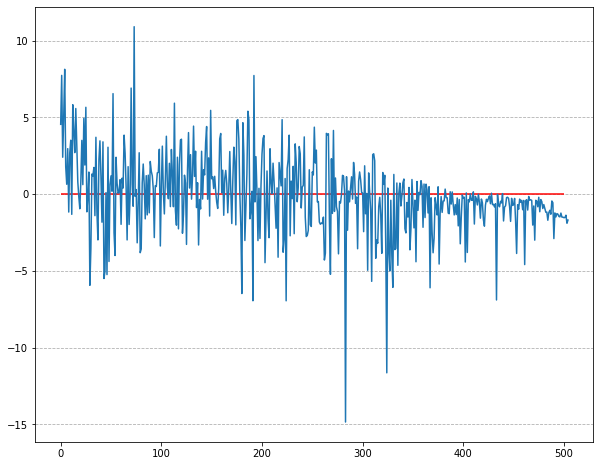

In [41]:
plt.figure(figsize=(10, 8))
plt.plot(both['sum_old'] - both['sum_new'])
plt.hlines(0, 0, 500, color='red')
plt.grid(axis='y', linestyle='--')
plt.show()

In [44]:
both[(both['sum_new'] - both['sum_old']) == (both['sum_new'] - both['sum_old']).max()]

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,model,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_closest_fpl_match,name_join_key,_merge
283,1.076248,1.063842,1.118668,1.097783,1.130245,5.486786,joão pedro cavaco_cancelo,1.0,0.0,0.0,0.0,Manchester City,5.1,lstm_v4,joao_pedro_cavaco_cancelo,5.149559,3.873785,3.953782,3.734438,3.622654,20.334219,joão_pedro cavaco cancelo,1.0,0.0,0.0,0.0,joao_pedro_cavaco_cancelo,NaN,joao_pedro_cavaco_cancelo,both


In [45]:
both[(both['sum_new'] - both['sum_old']) == (both['sum_new'] - both['sum_old']).min()]

,GW_plus_1_old,GW_plus_2_old,GW_plus_3_old,GW_plus_4_old,GW_plus_5_old,sum_old,name_old,position_DEF_old,position_FWD_old,position_GK_old,position_MID_old,team_name,next_match_value,model,name_formatted_old,GW_plus_1_new,GW_plus_2_new,GW_plus_3_new,GW_plus_4_new,GW_plus_5_new,sum_new,name_new,position_DEF_new,position_FWD_new,position_GK_new,position_MID_new,name_formatted_new,name_closest_fpl_match,name_join_key,_merge
73,2.717104,2.626874,2.648322,2.587111,2.602391,13.181801,sergio_agüero,0.0,1.0,0.0,0.0,Manchester City,11.7,lstm_v4,sergio_aguero,0.410013,0.359226,0.491538,0.471443,0.549141,2.281361,sergio_aguero,0.0,1.0,0.0,0.0,sergio_aguero,NaN,sergio_aguero,both


Looks like in both cases where there was a large discrepency the model made a sensible prediction. The old model predicted a large total for Agüero although he was injured (suspect this is driven by high ownership from players who stopped playing FPL) whereas the new model predicted a low total.

In [46]:
gw_38_player_data = pd.read_parquet('data/gw_player_data/gw_38_player_data.parquet')
print(gw_38_player_data.shape)
gw_38_player_data.head()

(22502, 52)


,total_points,was_home,team_h_score,team_a_score,gw,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Jul,kickoff_month_Jun,kickoff_month_Mar,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,0,False,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.5,0,33117,0,0,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Newcastle United,0,0,1,0,0,0,0,0,0,0,0,0,0,0,593
1,0,True,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.5,-5280,36709,2868,8148,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Burnley,0,0,1,0,0,0,0,0,0,0,0,0,0,1,593
2,0,False,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.4,-6882,30975,534,7416,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Liverpool,0,1,1,0,0,0,0,0,0,0,0,0,1,0,593
3,0,True,2,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.4,-3872,28096,346,4218,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Tottenham Hotspur,0,1,0,0,0,0,0,0,0,0,0,1,0,0,593
4,0,False,2,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.3,-2073,26902,581,2654,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0,593


In [47]:
gw_38_player_data[(gw_38_player_data['name'] == 'joão pedro cavaco_cancelo') & (gw_38_player_data['gw'] == 38 + 9)]['total_points']

11927    5
Name: total_points, dtype: int64

In [49]:
both_with_actuals = both.merge(gw_38_player_data[(gw_38_player_data['gw'] == 38 + 9)][['name', 'total_points']], left_on='name_old', right_on='name', how='inner')  # +9 for project restart

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [51]:
mean_squared_error(both_with_actuals['total_points'], both_with_actuals['GW_plus_1_old'])

5.093030809854695

In [52]:
mean_squared_error(both_with_actuals['total_points'], both_with_actuals['GW_plus_1_new'])

4.992022393927584

In [53]:
mean_absolute_error(both_with_actuals['total_points'], both_with_actuals['GW_plus_1_old'])

1.3356663470221037

In [54]:
mean_absolute_error(both_with_actuals['total_points'], both_with_actuals['GW_plus_1_new'])

1.2848319563830253